In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from scipy.sparse import csr_matrix

import sys

sys.path.insert(0, './code')
import dataloader
import trainer
import numpy as np

In [2]:
import importlib

loader = dataloader.DataLoader()
importlib.reload(trainer)
amt_handler = trainer.AmtTrainHandler()
profile_handler = trainer.AmtProfileHandler()
cnt_handler = trainer.CntTrainHandler()

In [3]:
profile_feats = loader.load_result("2021_12_17_light_profile_feats.joblib")
amt_feats = loader.load_result('2021_12_06_amt_feats.joblib')
cnt_feats = loader.load_result('2021_12_15_cnt_feats.joblib')
amt_feats = amt_feats.astype(np.int64)

In [4]:
non_imp_cates = [
    x for x in amt_handler.shop_cate if x not in amt_handler.ylabels
]
amt_drop_feats = []
cnt_drop_feats = []
for dt in range(2, 19):
    for non_imp_cate in non_imp_cates:
        amt_cate_col = "shop_{}_amt_{}".format(non_imp_cate, dt - 24)
        cnt_cate_col = "shop_{}_cnt_{}".format(non_imp_cate, dt - 24)
        amt_drop_feats.append(amt_cate_col)
        cnt_drop_feats.append(cnt_cate_col)

In [5]:
cnt_handler.update_data(cnt_feats)
cnt_handler.train = cnt_handler.train.reset_index(drop=True)
cnt_handler.test = cnt_handler.test.reset_index(drop=True)
cnt_handler.train = cnt_handler.train.drop(cnt_drop_feats, axis=1)
cnt_handler.test = cnt_handler.test.drop(cnt_drop_feats, axis=1)

Start Update Data
Start Processing y label
Start Processing train set
Start Processing test set
Finished updating data


In [6]:
cnt_train = cnt_handler.train.copy()
cnt_test = cnt_handler.test.copy()
cnt_test['dt'] = 25
cnt_train['dt'] = [23] * 500000 + [24] * 500000
ylabels = cnt_handler.y.copy()

In [7]:
amt_handler.update_data(amt_feats)
amt_handler.X = amt_handler.X.drop(amt_drop_feats, axis=1)
amt_handler.test = amt_handler.test.drop(amt_drop_feats, axis=1)
amt_test = amt_handler.test.copy()
amt_train = amt_handler.X.copy()

Start Update Data
Finished updating data


In [8]:
amt_train = amt_train.reset_index(drop=True)
amt_test = amt_test.reset_index(drop=True)

cnt_train = cnt_train.reset_index(drop=True)
cnt_test = cnt_test.reset_index(drop=True)

In [9]:
profile_handler.update_data(profile_feats)
cnt_train = pd.merge(cnt_train, profile_feats, on=['chid', 'dt'], how='left')
cnt_test = pd.merge(cnt_test, profile_feats, on=['chid', 'dt'], how='left')

Start Update Data
Finished updating data
start label encoding
Finish labor encoding


In [10]:
cnt_train = profile_handler.transform(cnt_train)
cnt_test = profile_handler.transform(cnt_test)

In [11]:
import gc

del amt_feats
del cnt_feats
del profile_feats

gc.collect()

63

In [12]:
cnt_train = cnt_train.drop(['chid', 'dt'], axis=1)
cnt_test = cnt_test.drop(['chid', 'dt'], axis=1)

amt_train = amt_train.drop(['chid'], axis=1)
amt_test = amt_test.drop(['chid'], axis=1)

In [13]:
cnt_train = pd.concat([cnt_train, amt_train], axis=1)
cnt_test = pd.concat([cnt_test, amt_test], axis=1)

In [14]:
_, _, idx_results = loader.load_result('2021_12_20_amt_train_results.joblib')


In [15]:
seed = 29

params = {
    'learning_rate': 0.01,
    'lambda_l1': 0.0009782288206799821,
    'lambda_l2': 0.00021248013254914345,
    'num_leaves': 1500,
    'feature_fraction': 0.25633622082985474,
    'feature_fraction_bynode': 0.8,
    'bagging_fraction': 0.8504557457590274,
    'bagging_freq': 16,
    'min_child_samples': 500,
    'max_depth': 20,
    'seed': seed,
    'feature_fraction_seed': seed,
    'bagging_seed': seed,
    'drop_seed': seed,
    'data_random_seed': seed,
    'objective': 'binary',
    'metric': 'auc',
    'boosting': 'gbdt',
    'verbosity': -1,
    'n_jobs': -1,
}


In [16]:
X = cnt_train.copy()
y = ylabels.reset_index(drop=True).copy()

Training fold 1


/Users/qin/workspace/pydata/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/qin/workspace/pydata/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/qin/workspace/pydata/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/qin/workspace/pydata/lib/python3.9/site-packages/lightgbm/basic.py:1

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.861131	valid_1's auc: 0.854575
[100]	training's auc: 0.863801	valid_1's auc: 0.855489
[150]	training's auc: 0.866581	valid_1's auc: 0.856671
[200]	training's auc: 0.868961	valid_1's auc: 0.857358
[250]	training's auc: 0.87136	valid_1's auc: 0.857949
[300]	training's auc: 0.873634	valid_1's auc: 0.858369
[350]	training's auc: 0.875867	valid_1's auc: 0.858748
[400]	training's auc: 0.878037	valid_1's auc: 0.859102
[450]	training's auc: 0.880013	valid_1's auc: 0.859337
[500]	training's auc: 0.881817	valid_1's auc: 0.859542
[550]	training's auc: 0.883365	valid_1's auc: 0.859674
[600]	training's auc: 0.884704	valid_1's auc: 0.859797
[650]	training's auc: 0.885947	valid_1's auc: 0.859885
[700]	training's auc: 0.88693	valid_1's auc: 0.85994
[750]	training's auc: 0.887802	valid_1's auc: 0.859993
[800]	training's auc: 0.888682	valid_1's auc: 0.860045
[850]	training's auc: 0.889451	valid_1's auc: 0.860067
[900]	t

<Figure size 864x432 with 0 Axes>

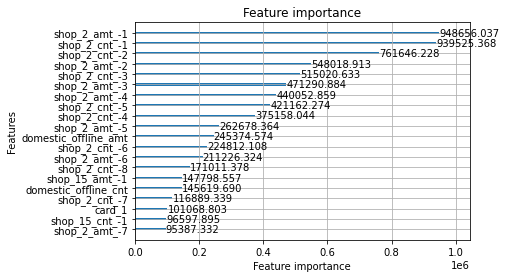

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.90956	valid_1's auc: 0.89596
[100]	training's auc: 0.913033	valid_1's auc: 0.89653
[150]	training's auc: 0.91639	valid_1's auc: 0.897023
[200]	training's auc: 0.920163	valid_1's auc: 0.897506
[250]	training's auc: 0.923778	valid_1's auc: 0.897873
[300]	training's auc: 0.927408	valid_1's auc: 0.898106
[350]	training's auc: 0.930695	valid_1's auc: 0.898379
[400]	training's auc: 0.933661	valid_1's auc: 0.898569
[450]	training's auc: 0.936148	valid_1's auc: 0.898746
[500]	training's auc: 0.938201	valid_1's auc: 0.898955
[550]	training's auc: 0.940065	valid_1's auc: 0.89909
[600]	training's auc: 0.941703	valid_1's auc: 0.899174
[650]	training's auc: 0.94301	valid_1's auc: 0.899215
[700]	training's auc: 0.944212	valid_1's auc: 0.899275
[750]	training's auc: 0.945427	valid_1's auc: 0.899297
[800]	training's auc: 0.946416	valid_1's auc: 0.899332
[850]	training's auc: 0.947351	valid_1's auc: 0.899327
[900]	trai

<Figure size 864x432 with 0 Axes>

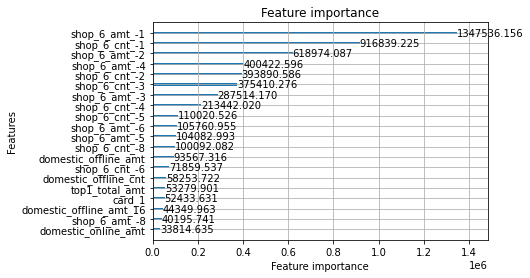

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.926406	valid_1's auc: 0.922349
[100]	training's auc: 0.927535	valid_1's auc: 0.92272
[150]	training's auc: 0.928863	valid_1's auc: 0.923198
[200]	training's auc: 0.930179	valid_1's auc: 0.923555
[250]	training's auc: 0.931587	valid_1's auc: 0.923895
[300]	training's auc: 0.933105	valid_1's auc: 0.924302
[350]	training's auc: 0.934565	valid_1's auc: 0.924598
[400]	training's auc: 0.936051	valid_1's auc: 0.924903
[450]	training's auc: 0.937463	valid_1's auc: 0.925169
[500]	training's auc: 0.938788	valid_1's auc: 0.925407
[550]	training's auc: 0.939885	valid_1's auc: 0.925546
[600]	training's auc: 0.941011	valid_1's auc: 0.925769
[650]	training's auc: 0.942003	valid_1's auc: 0.925893
[700]	training's auc: 0.94288	valid_1's auc: 0.925999
[750]	training's auc: 0.943735	valid_1's auc: 0.926095
[800]	training's auc: 0.944463	valid_1's auc: 0.926167
[850]	training's auc: 0.945137	valid_1's auc: 0.926224
[900]	

<Figure size 864x432 with 0 Axes>

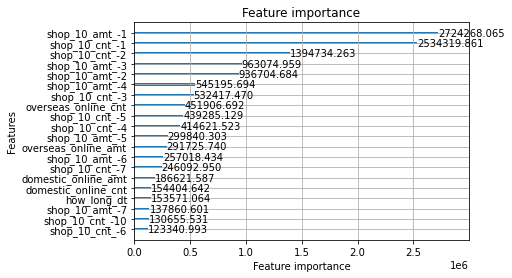

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.924529	valid_1's auc: 0.915637
[100]	training's auc: 0.926503	valid_1's auc: 0.916296
[150]	training's auc: 0.928371	valid_1's auc: 0.916691
[200]	training's auc: 0.930524	valid_1's auc: 0.917022
[250]	training's auc: 0.932694	valid_1's auc: 0.917294
[300]	training's auc: 0.934946	valid_1's auc: 0.917603
[350]	training's auc: 0.937222	valid_1's auc: 0.917929
[400]	training's auc: 0.939396	valid_1's auc: 0.918122
[450]	training's auc: 0.941317	valid_1's auc: 0.918307
[500]	training's auc: 0.942946	valid_1's auc: 0.918457
[550]	training's auc: 0.944449	valid_1's auc: 0.918551
[600]	training's auc: 0.945669	valid_1's auc: 0.918601
[650]	training's auc: 0.946786	valid_1's auc: 0.918661
[700]	training's auc: 0.947765	valid_1's auc: 0.918721
[750]	training's auc: 0.948606	valid_1's auc: 0.918754
[800]	training's auc: 0.949315	valid_1's auc: 0.918754
[850]	training's auc: 0.950093	valid_1's auc: 0.91875
[900]

<Figure size 864x432 with 0 Axes>

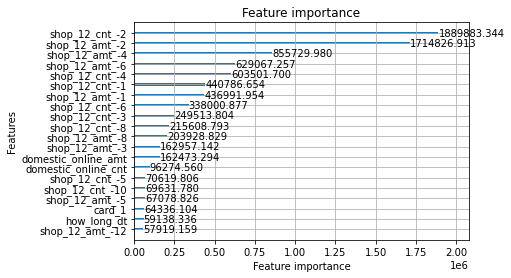

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.959572	valid_1's auc: 0.953688
[100]	training's auc: 0.961047	valid_1's auc: 0.954237
[150]	training's auc: 0.962655	valid_1's auc: 0.954846
[200]	training's auc: 0.964332	valid_1's auc: 0.9554
[250]	training's auc: 0.965971	valid_1's auc: 0.955876
[300]	training's auc: 0.967473	valid_1's auc: 0.956245
[350]	training's auc: 0.968993	valid_1's auc: 0.95653
[400]	training's auc: 0.970481	valid_1's auc: 0.956867
[450]	training's auc: 0.971935	valid_1's auc: 0.957126
[500]	training's auc: 0.973186	valid_1's auc: 0.957413
[550]	training's auc: 0.97424	valid_1's auc: 0.957555
[600]	training's auc: 0.975166	valid_1's auc: 0.957765
[650]	training's auc: 0.976045	valid_1's auc: 0.957936
[700]	training's auc: 0.976844	valid_1's auc: 0.958048
[750]	training's auc: 0.977426	valid_1's auc: 0.958124
[800]	training's auc: 0.978081	valid_1's auc: 0.958207
[850]	training's auc: 0.978661	valid_1's auc: 0.958277
[900]	tr

<Figure size 864x432 with 0 Axes>

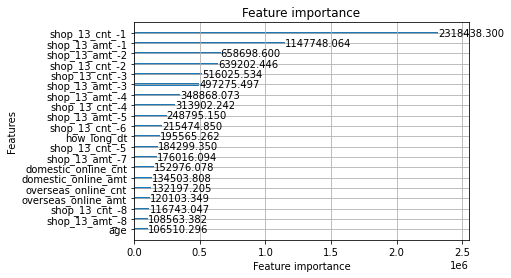

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.880067	valid_1's auc: 0.873108
[100]	training's auc: 0.881751	valid_1's auc: 0.873789
[150]	training's auc: 0.883789	valid_1's auc: 0.874723
[200]	training's auc: 0.885715	valid_1's auc: 0.875353
[250]	training's auc: 0.887549	valid_1's auc: 0.875916
[300]	training's auc: 0.889394	valid_1's auc: 0.876387
[350]	training's auc: 0.891108	valid_1's auc: 0.876729
[400]	training's auc: 0.892781	valid_1's auc: 0.877051
[450]	training's auc: 0.89433	valid_1's auc: 0.87733
[500]	training's auc: 0.895633	valid_1's auc: 0.877535
[550]	training's auc: 0.896839	valid_1's auc: 0.877718
[600]	training's auc: 0.897905	valid_1's auc: 0.877865
[650]	training's auc: 0.898804	valid_1's auc: 0.877982
[700]	training's auc: 0.899565	valid_1's auc: 0.878074
[750]	training's auc: 0.900262	valid_1's auc: 0.878148
[800]	training's auc: 0.900891	valid_1's auc: 0.878202
[850]	training's auc: 0.901542	valid_1's auc: 0.878236
[900]	

<Figure size 864x432 with 0 Axes>

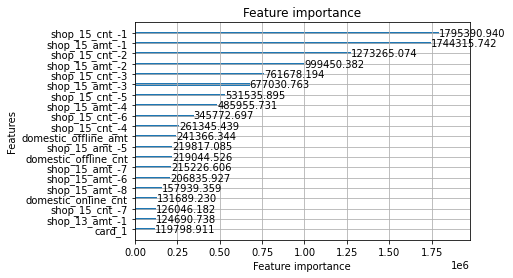

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.869524	valid_1's auc: 0.853868
[100]	training's auc: 0.87425	valid_1's auc: 0.855031
[150]	training's auc: 0.87852	valid_1's auc: 0.855949
[200]	training's auc: 0.882534	valid_1's auc: 0.856475
[250]	training's auc: 0.886545	valid_1's auc: 0.857017
[300]	training's auc: 0.890369	valid_1's auc: 0.857442
[350]	training's auc: 0.894042	valid_1's auc: 0.857761
[400]	training's auc: 0.897369	valid_1's auc: 0.858005
[450]	training's auc: 0.900328	valid_1's auc: 0.85823
[500]	training's auc: 0.902804	valid_1's auc: 0.858384
[550]	training's auc: 0.904894	valid_1's auc: 0.858518
[600]	training's auc: 0.906588	valid_1's auc: 0.858579
[650]	training's auc: 0.908141	valid_1's auc: 0.858636
[700]	training's auc: 0.90968	valid_1's auc: 0.85868
[750]	training's auc: 0.910844	valid_1's auc: 0.858714
[800]	training's auc: 0.91209	valid_1's auc: 0.858739
[850]	training's auc: 0.913181	valid_1's auc: 0.858729
[900]	trai

<Figure size 864x432 with 0 Axes>

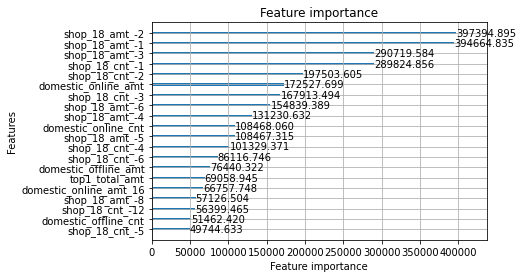

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.830886	valid_1's auc: 0.813919
[100]	training's auc: 0.835679	valid_1's auc: 0.815512
[150]	training's auc: 0.840181	valid_1's auc: 0.816579
[200]	training's auc: 0.844948	valid_1's auc: 0.817535
[250]	training's auc: 0.849261	valid_1's auc: 0.818314
[300]	training's auc: 0.853425	valid_1's auc: 0.81893
[350]	training's auc: 0.857178	valid_1's auc: 0.819453
[400]	training's auc: 0.860684	valid_1's auc: 0.819809
[450]	training's auc: 0.863651	valid_1's auc: 0.820067
[500]	training's auc: 0.866423	valid_1's auc: 0.820311
[550]	training's auc: 0.868864	valid_1's auc: 0.820513
[600]	training's auc: 0.871271	valid_1's auc: 0.820661
[650]	training's auc: 0.873178	valid_1's auc: 0.820783
[700]	training's auc: 0.874994	valid_1's auc: 0.82085
[750]	training's auc: 0.87678	valid_1's auc: 0.82091
[800]	training's auc: 0.878417	valid_1's auc: 0.820965
[850]	training's auc: 0.879913	valid_1's auc: 0.821012
[900]	tr

<Figure size 864x432 with 0 Axes>

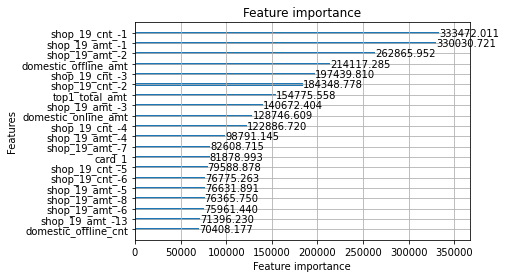

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.840556	valid_1's auc: 0.822249
[100]	training's auc: 0.846616	valid_1's auc: 0.823808
[150]	training's auc: 0.852213	valid_1's auc: 0.825006
[200]	training's auc: 0.857573	valid_1's auc: 0.826033
[250]	training's auc: 0.862254	valid_1's auc: 0.826713
[300]	training's auc: 0.866991	valid_1's auc: 0.827334
[350]	training's auc: 0.871097	valid_1's auc: 0.827798
[400]	training's auc: 0.874827	valid_1's auc: 0.828175
[450]	training's auc: 0.877795	valid_1's auc: 0.828486
[500]	training's auc: 0.880385	valid_1's auc: 0.828681
[550]	training's auc: 0.882767	valid_1's auc: 0.828805
[600]	training's auc: 0.884521	valid_1's auc: 0.828915
[650]	training's auc: 0.886094	valid_1's auc: 0.829051
[700]	training's auc: 0.887527	valid_1's auc: 0.829078
[750]	training's auc: 0.889005	valid_1's auc: 0.829127
[800]	training's auc: 0.890254	valid_1's auc: 0.829123
Early stopping, best iteration is:
[739]	training's auc: 0.

<Figure size 864x432 with 0 Axes>

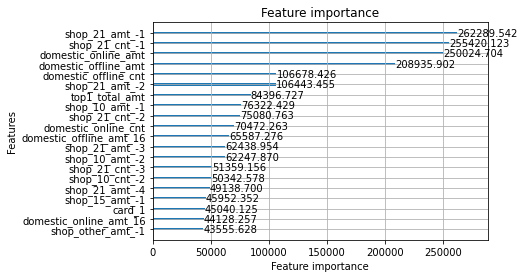

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.892085	valid_1's auc: 0.875736
[100]	training's auc: 0.895694	valid_1's auc: 0.876923
[150]	training's auc: 0.89915	valid_1's auc: 0.877679
[200]	training's auc: 0.902416	valid_1's auc: 0.878096
[250]	training's auc: 0.905586	valid_1's auc: 0.878489
[300]	training's auc: 0.908959	valid_1's auc: 0.878832
[350]	training's auc: 0.912099	valid_1's auc: 0.879106
[400]	training's auc: 0.915231	valid_1's auc: 0.879405
[450]	training's auc: 0.918032	valid_1's auc: 0.879613
[500]	training's auc: 0.920388	valid_1's auc: 0.879737
[550]	training's auc: 0.922259	valid_1's auc: 0.879802
[600]	training's auc: 0.924054	valid_1's auc: 0.879895
[650]	training's auc: 0.925711	valid_1's auc: 0.879902
[700]	training's auc: 0.927315	valid_1's auc: 0.879914
[750]	training's auc: 0.928742	valid_1's auc: 0.879946
[800]	training's auc: 0.92996	valid_1's auc: 0.879937
[850]	training's auc: 0.931025	valid_1's auc: 0.879926
Early 

<Figure size 864x432 with 0 Axes>

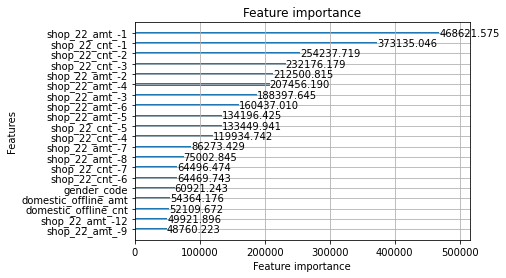

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.876741	valid_1's auc: 0.86371
[100]	training's auc: 0.880534	valid_1's auc: 0.864685
[150]	training's auc: 0.884059	valid_1's auc: 0.865414
[200]	training's auc: 0.887706	valid_1's auc: 0.866056
[250]	training's auc: 0.891284	valid_1's auc: 0.866599
[300]	training's auc: 0.894673	valid_1's auc: 0.867003
[350]	training's auc: 0.89792	valid_1's auc: 0.867324
[400]	training's auc: 0.900796	valid_1's auc: 0.867571
[450]	training's auc: 0.90347	valid_1's auc: 0.867801
[500]	training's auc: 0.90576	valid_1's auc: 0.867969
[550]	training's auc: 0.907783	valid_1's auc: 0.868113
[600]	training's auc: 0.909491	valid_1's auc: 0.868216
[650]	training's auc: 0.911179	valid_1's auc: 0.86827
[700]	training's auc: 0.912447	valid_1's auc: 0.868301
[750]	training's auc: 0.91354	valid_1's auc: 0.868329
[800]	training's auc: 0.914719	valid_1's auc: 0.868339
[850]	training's auc: 0.915798	valid_1's auc: 0.86834
[900]	train

<Figure size 864x432 with 0 Axes>

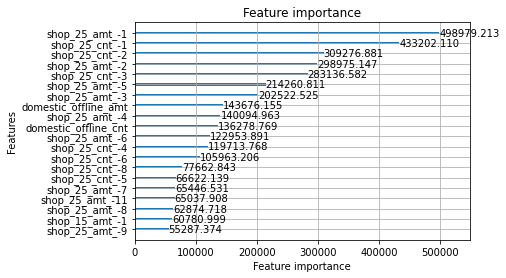

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.893048	valid_1's auc: 0.873679
[100]	training's auc: 0.897081	valid_1's auc: 0.874415
[150]	training's auc: 0.901143	valid_1's auc: 0.874922
[200]	training's auc: 0.905189	valid_1's auc: 0.875408
[250]	training's auc: 0.909519	valid_1's auc: 0.875809
[300]	training's auc: 0.913789	valid_1's auc: 0.876098
[350]	training's auc: 0.917553	valid_1's auc: 0.87637
[400]	training's auc: 0.920875	valid_1's auc: 0.87656
[450]	training's auc: 0.923809	valid_1's auc: 0.876767
[500]	training's auc: 0.926491	valid_1's auc: 0.876845
[550]	training's auc: 0.928704	valid_1's auc: 0.876935
[600]	training's auc: 0.930456	valid_1's auc: 0.876993
[650]	training's auc: 0.932198	valid_1's auc: 0.877023
[700]	training's auc: 0.933616	valid_1's auc: 0.877045
[750]	training's auc: 0.93497	valid_1's auc: 0.877025
[800]	training's auc: 0.93609	valid_1's auc: 0.877017
Early stopping, best iteration is:
[702]	training's auc: 0.9336

<Figure size 864x432 with 0 Axes>

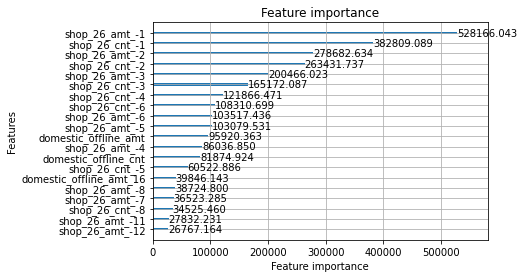

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.942963	valid_1's auc: 0.940108
[100]	training's auc: 0.943596	valid_1's auc: 0.940275
[150]	training's auc: 0.944501	valid_1's auc: 0.940624
[200]	training's auc: 0.945591	valid_1's auc: 0.941058
[250]	training's auc: 0.946587	valid_1's auc: 0.941362
[300]	training's auc: 0.947679	valid_1's auc: 0.941641
[350]	training's auc: 0.948745	valid_1's auc: 0.941844
[400]	training's auc: 0.949826	valid_1's auc: 0.942025
[450]	training's auc: 0.950826	valid_1's auc: 0.942196
[500]	training's auc: 0.951804	valid_1's auc: 0.942323
[550]	training's auc: 0.952665	valid_1's auc: 0.942424
[600]	training's auc: 0.953403	valid_1's auc: 0.942512
[650]	training's auc: 0.954036	valid_1's auc: 0.94262
[700]	training's auc: 0.954619	valid_1's auc: 0.942693
[750]	training's auc: 0.95511	valid_1's auc: 0.942737
[800]	training's auc: 0.955581	valid_1's auc: 0.942779
[850]	training's auc: 0.956063	valid_1's auc: 0.942804
[900]	

<Figure size 864x432 with 0 Axes>

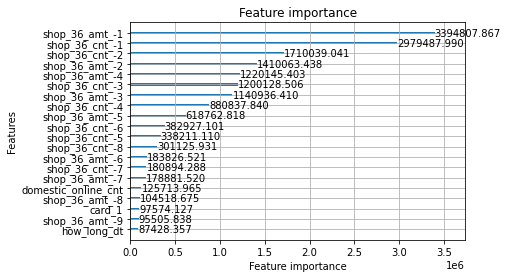

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.880754	valid_1's auc: 0.875435
[100]	training's auc: 0.882433	valid_1's auc: 0.876294
[150]	training's auc: 0.883969	valid_1's auc: 0.876813
[200]	training's auc: 0.885523	valid_1's auc: 0.87728
[250]	training's auc: 0.887234	valid_1's auc: 0.877783
[300]	training's auc: 0.888883	valid_1's auc: 0.87814
[350]	training's auc: 0.89048	valid_1's auc: 0.878508
[400]	training's auc: 0.892113	valid_1's auc: 0.878847
[450]	training's auc: 0.893634	valid_1's auc: 0.87913
[500]	training's auc: 0.895	valid_1's auc: 0.879339
[550]	training's auc: 0.896243	valid_1's auc: 0.879505
[600]	training's auc: 0.897452	valid_1's auc: 0.879646
[650]	training's auc: 0.898479	valid_1's auc: 0.87977
[700]	training's auc: 0.899435	valid_1's auc: 0.879864
[750]	training's auc: 0.900275	valid_1's auc: 0.879933
[800]	training's auc: 0.901122	valid_1's auc: 0.879988
[850]	training's auc: 0.901738	valid_1's auc: 0.880023
[900]	traini

<Figure size 864x432 with 0 Axes>

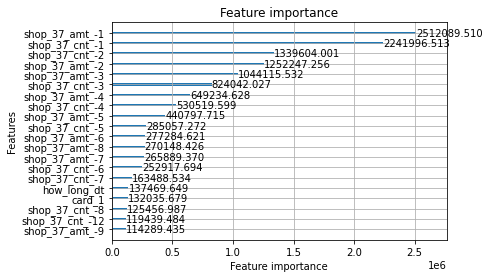

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.878544	valid_1's auc: 0.85699
[100]	training's auc: 0.883874	valid_1's auc: 0.858233
[150]	training's auc: 0.888798	valid_1's auc: 0.859191
[200]	training's auc: 0.893264	valid_1's auc: 0.859769
[250]	training's auc: 0.897617	valid_1's auc: 0.860281
[300]	training's auc: 0.901506	valid_1's auc: 0.860689
[350]	training's auc: 0.905071	valid_1's auc: 0.861043
[400]	training's auc: 0.908027	valid_1's auc: 0.861291
[450]	training's auc: 0.91045	valid_1's auc: 0.861469
[500]	training's auc: 0.912494	valid_1's auc: 0.86159
[550]	training's auc: 0.914312	valid_1's auc: 0.861698
[600]	training's auc: 0.916102	valid_1's auc: 0.861746
[650]	training's auc: 0.917728	valid_1's auc: 0.861774
[700]	training's auc: 0.919169	valid_1's auc: 0.861817
[750]	training's auc: 0.920528	valid_1's auc: 0.861832
[800]	training's auc: 0.921921	valid_1's auc: 0.861846
[850]	training's auc: 0.923397	valid_1's auc: 0.861782
Early s

<Figure size 864x432 with 0 Axes>

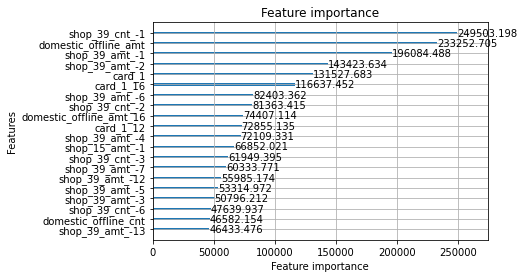

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.911783	valid_1's auc: 0.906143
[100]	training's auc: 0.913418	valid_1's auc: 0.906836
[150]	training's auc: 0.915084	valid_1's auc: 0.907351
[200]	training's auc: 0.916671	valid_1's auc: 0.907741
[250]	training's auc: 0.918346	valid_1's auc: 0.908054
[300]	training's auc: 0.920053	valid_1's auc: 0.908332
[350]	training's auc: 0.921757	valid_1's auc: 0.908555
[400]	training's auc: 0.923433	valid_1's auc: 0.908759
[450]	training's auc: 0.924983	valid_1's auc: 0.908969
[500]	training's auc: 0.926351	valid_1's auc: 0.909112
[550]	training's auc: 0.927576	valid_1's auc: 0.909231
[600]	training's auc: 0.928569	valid_1's auc: 0.909308
[650]	training's auc: 0.929442	valid_1's auc: 0.909372
[700]	training's auc: 0.930197	valid_1's auc: 0.909422
[750]	training's auc: 0.930911	valid_1's auc: 0.909461
[800]	training's auc: 0.93164	valid_1's auc: 0.90949
[850]	training's auc: 0.932227	valid_1's auc: 0.909518
[900]	

<Figure size 864x432 with 0 Axes>

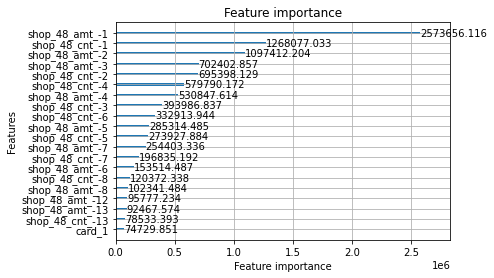

Training fold 2
Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.862043	valid_1's auc: 0.852715
[100]	training's auc: 0.864823	valid_1's auc: 0.854065
[150]	training's auc: 0.867377	valid_1's auc: 0.854982
[200]	training's auc: 0.869769	valid_1's auc: 0.855642
[250]	training's auc: 0.872112	valid_1's auc: 0.856093
[300]	training's auc: 0.874452	valid_1's auc: 0.856553
[350]	training's auc: 0.876646	valid_1's auc: 0.856907
[400]	training's auc: 0.878809	valid_1's auc: 0.857236
[450]	training's auc: 0.880848	valid_1's auc: 0.85751
[500]	training's auc: 0.882556	valid_1's auc: 0.857707
[550]	training's auc: 0.884085	valid_1's auc: 0.857874
[600]	training's auc: 0.885556	valid_1's auc: 0.858021
[650]	training's auc: 0.886808	valid_1's auc: 0.85813
[700]	training's auc: 0.887841	valid_1's auc: 0.858198
[750]	training's auc: 0.888911	valid_1's auc: 0.858268
[800]	training's auc: 0.889712	valid_1's auc: 0.858306
[850]	training's auc: 0.890645	valid_1's auc:

<Figure size 864x432 with 0 Axes>

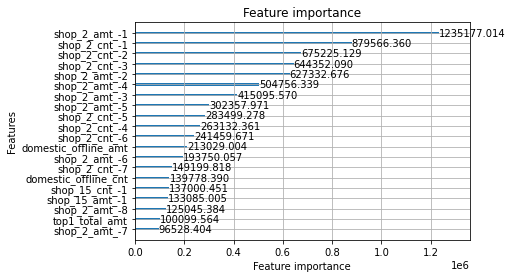

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.909905	valid_1's auc: 0.893856
[100]	training's auc: 0.913443	valid_1's auc: 0.8947
[150]	training's auc: 0.916973	valid_1's auc: 0.895189
[200]	training's auc: 0.920404	valid_1's auc: 0.895898
[250]	training's auc: 0.923793	valid_1's auc: 0.896373
[300]	training's auc: 0.92731	valid_1's auc: 0.896731
[350]	training's auc: 0.930182	valid_1's auc: 0.896919
[400]	training's auc: 0.933036	valid_1's auc: 0.897207
[450]	training's auc: 0.935472	valid_1's auc: 0.897387
[500]	training's auc: 0.937638	valid_1's auc: 0.897565
[550]	training's auc: 0.939553	valid_1's auc: 0.897661
[600]	training's auc: 0.941053	valid_1's auc: 0.897722
[650]	training's auc: 0.942377	valid_1's auc: 0.89779
[700]	training's auc: 0.943508	valid_1's auc: 0.897818
[750]	training's auc: 0.94478	valid_1's auc: 0.897857
[800]	training's auc: 0.945776	valid_1's auc: 0.897876
[850]	training's auc: 0.946686	valid_1's auc: 0.897877
[900]	tra

<Figure size 864x432 with 0 Axes>

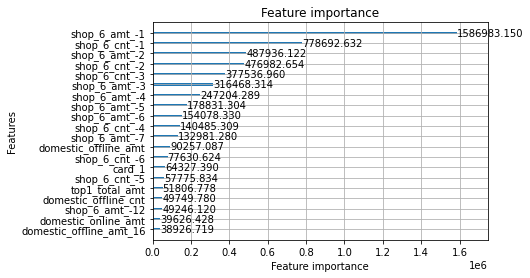

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.926573	valid_1's auc: 0.922953
[100]	training's auc: 0.927729	valid_1's auc: 0.923354
[150]	training's auc: 0.928958	valid_1's auc: 0.923739
[200]	training's auc: 0.9302	valid_1's auc: 0.924061
[250]	training's auc: 0.931602	valid_1's auc: 0.924413
[300]	training's auc: 0.933084	valid_1's auc: 0.924774
[350]	training's auc: 0.934635	valid_1's auc: 0.925099
[400]	training's auc: 0.936097	valid_1's auc: 0.925354
[450]	training's auc: 0.937531	valid_1's auc: 0.92562
[500]	training's auc: 0.93878	valid_1's auc: 0.92581
[550]	training's auc: 0.939889	valid_1's auc: 0.925975
[600]	training's auc: 0.940981	valid_1's auc: 0.926122
[650]	training's auc: 0.941914	valid_1's auc: 0.926225
[700]	training's auc: 0.942768	valid_1's auc: 0.926327
[750]	training's auc: 0.94349	valid_1's auc: 0.926374
[800]	training's auc: 0.94429	valid_1's auc: 0.926458
[850]	training's auc: 0.944984	valid_1's auc: 0.926517
[900]	train

<Figure size 864x432 with 0 Axes>

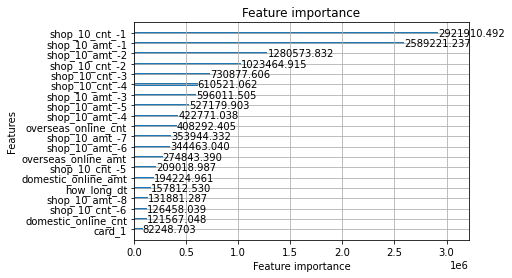

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.923724	valid_1's auc: 0.916433
[100]	training's auc: 0.925625	valid_1's auc: 0.916923
[150]	training's auc: 0.927705	valid_1's auc: 0.917415
[200]	training's auc: 0.929886	valid_1's auc: 0.917803
[250]	training's auc: 0.931984	valid_1's auc: 0.918115
[300]	training's auc: 0.934334	valid_1's auc: 0.918504
[350]	training's auc: 0.936588	valid_1's auc: 0.918792
[400]	training's auc: 0.938561	valid_1's auc: 0.919044
[450]	training's auc: 0.94036	valid_1's auc: 0.919229
[500]	training's auc: 0.942036	valid_1's auc: 0.919438
[550]	training's auc: 0.943447	valid_1's auc: 0.919591
[600]	training's auc: 0.944581	valid_1's auc: 0.919674
[650]	training's auc: 0.945703	valid_1's auc: 0.919754
[700]	training's auc: 0.946656	valid_1's auc: 0.919797
[750]	training's auc: 0.947542	valid_1's auc: 0.919858
[800]	training's auc: 0.948405	valid_1's auc: 0.919873
[850]	training's auc: 0.949052	valid_1's auc: 0.919889
[900]

<Figure size 864x432 with 0 Axes>

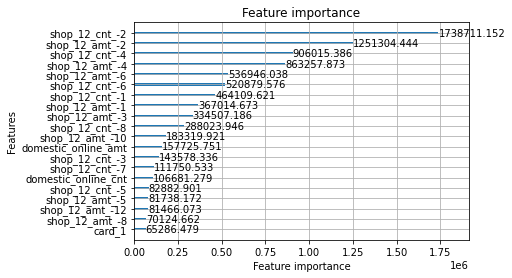

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.959095	valid_1's auc: 0.952552
[100]	training's auc: 0.960636	valid_1's auc: 0.953077
[150]	training's auc: 0.962681	valid_1's auc: 0.954039
[200]	training's auc: 0.96422	valid_1's auc: 0.954511
[250]	training's auc: 0.965897	valid_1's auc: 0.955046
[300]	training's auc: 0.967518	valid_1's auc: 0.955521
[350]	training's auc: 0.9691	valid_1's auc: 0.955898
[400]	training's auc: 0.970618	valid_1's auc: 0.956167
[450]	training's auc: 0.972092	valid_1's auc: 0.956436
[500]	training's auc: 0.973349	valid_1's auc: 0.956667
[550]	training's auc: 0.974521	valid_1's auc: 0.956862
[600]	training's auc: 0.975388	valid_1's auc: 0.95703
[650]	training's auc: 0.976295	valid_1's auc: 0.95721
[700]	training's auc: 0.977033	valid_1's auc: 0.957366
[750]	training's auc: 0.977706	valid_1's auc: 0.957458
[800]	training's auc: 0.978361	valid_1's auc: 0.957528
[850]	training's auc: 0.97887	valid_1's auc: 0.957571
[900]	trai

<Figure size 864x432 with 0 Axes>

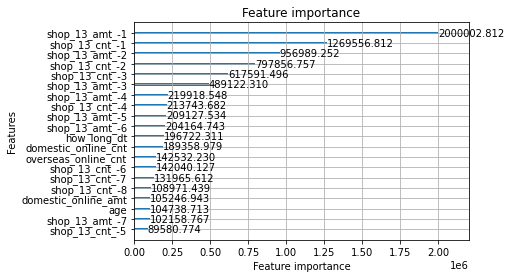

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.879067	valid_1's auc: 0.87467
[100]	training's auc: 0.881016	valid_1's auc: 0.875536
[150]	training's auc: 0.882744	valid_1's auc: 0.87614
[200]	training's auc: 0.88466	valid_1's auc: 0.876794
[250]	training's auc: 0.886584	valid_1's auc: 0.877367
[300]	training's auc: 0.888524	valid_1's auc: 0.877936
[350]	training's auc: 0.890313	valid_1's auc: 0.878318
[400]	training's auc: 0.892052	valid_1's auc: 0.878632
[450]	training's auc: 0.893592	valid_1's auc: 0.878889
[500]	training's auc: 0.89488	valid_1's auc: 0.8791
[550]	training's auc: 0.896086	valid_1's auc: 0.879261
[600]	training's auc: 0.897157	valid_1's auc: 0.879404
[650]	training's auc: 0.898167	valid_1's auc: 0.879509
[700]	training's auc: 0.898948	valid_1's auc: 0.879598
[750]	training's auc: 0.899696	valid_1's auc: 0.879662
[800]	training's auc: 0.900333	valid_1's auc: 0.879713
[850]	training's auc: 0.900922	valid_1's auc: 0.879745
[900]	trai

<Figure size 864x432 with 0 Axes>

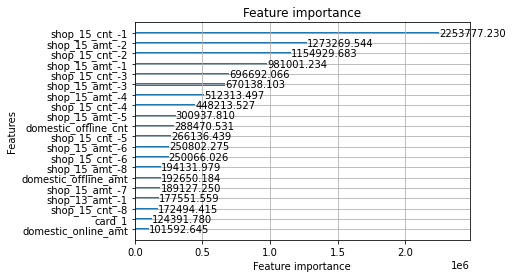

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.869299	valid_1's auc: 0.853535
[100]	training's auc: 0.874016	valid_1's auc: 0.855104
[150]	training's auc: 0.878155	valid_1's auc: 0.856014
[200]	training's auc: 0.882374	valid_1's auc: 0.856657
[250]	training's auc: 0.886395	valid_1's auc: 0.85725
[300]	training's auc: 0.890306	valid_1's auc: 0.857761
[350]	training's auc: 0.893776	valid_1's auc: 0.858148
[400]	training's auc: 0.89694	valid_1's auc: 0.858464
[450]	training's auc: 0.899917	valid_1's auc: 0.858676
[500]	training's auc: 0.90232	valid_1's auc: 0.858845
[550]	training's auc: 0.904087	valid_1's auc: 0.858959
[600]	training's auc: 0.905683	valid_1's auc: 0.859024
[650]	training's auc: 0.907339	valid_1's auc: 0.859137
[700]	training's auc: 0.908716	valid_1's auc: 0.85919
[750]	training's auc: 0.909806	valid_1's auc: 0.859197
[800]	training's auc: 0.911104	valid_1's auc: 0.85919
[850]	training's auc: 0.912231	valid_1's auc: 0.859186
Early sto

<Figure size 864x432 with 0 Axes>

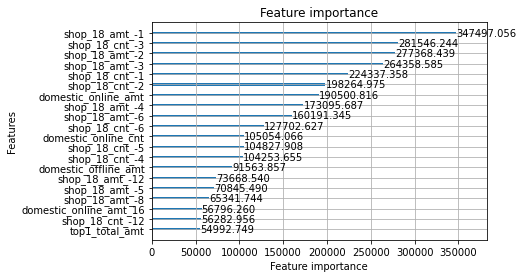

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.830297	valid_1's auc: 0.815487
[100]	training's auc: 0.835024	valid_1's auc: 0.816871
[150]	training's auc: 0.8398	valid_1's auc: 0.818079
[200]	training's auc: 0.844413	valid_1's auc: 0.819113
[250]	training's auc: 0.848844	valid_1's auc: 0.819973
[300]	training's auc: 0.852925	valid_1's auc: 0.820579
[350]	training's auc: 0.856714	valid_1's auc: 0.821068
[400]	training's auc: 0.860241	valid_1's auc: 0.821461
[450]	training's auc: 0.863354	valid_1's auc: 0.821774
[500]	training's auc: 0.866229	valid_1's auc: 0.822032
[550]	training's auc: 0.868898	valid_1's auc: 0.822235
[600]	training's auc: 0.871077	valid_1's auc: 0.822378
[650]	training's auc: 0.873034	valid_1's auc: 0.822517
[700]	training's auc: 0.874666	valid_1's auc: 0.822575
[750]	training's auc: 0.876435	valid_1's auc: 0.822638
[800]	training's auc: 0.877797	valid_1's auc: 0.822669
[850]	training's auc: 0.879285	valid_1's auc: 0.822716
[900]	

<Figure size 864x432 with 0 Axes>

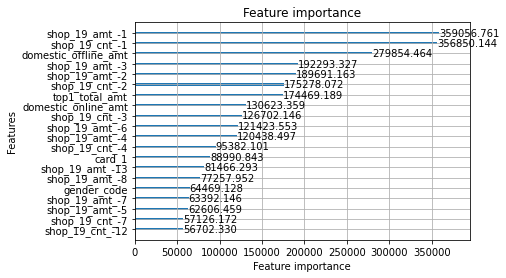

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.842575	valid_1's auc: 0.818811
[100]	training's auc: 0.848583	valid_1's auc: 0.820046
[150]	training's auc: 0.854084	valid_1's auc: 0.821042
[200]	training's auc: 0.859298	valid_1's auc: 0.821858
[250]	training's auc: 0.864166	valid_1's auc: 0.822712
[300]	training's auc: 0.868755	valid_1's auc: 0.823245
[350]	training's auc: 0.872881	valid_1's auc: 0.823732
[400]	training's auc: 0.87651	valid_1's auc: 0.82408
[450]	training's auc: 0.879822	valid_1's auc: 0.824292
[500]	training's auc: 0.882236	valid_1's auc: 0.824474
[550]	training's auc: 0.884194	valid_1's auc: 0.824597
[600]	training's auc: 0.885843	valid_1's auc: 0.824656
[650]	training's auc: 0.887491	valid_1's auc: 0.824733
[700]	training's auc: 0.888941	valid_1's auc: 0.82478
[750]	training's auc: 0.89062	valid_1's auc: 0.824775
[800]	training's auc: 0.89226	valid_1's auc: 0.824805
[850]	training's auc: 0.893613	valid_1's auc: 0.824843
[900]	tra

<Figure size 864x432 with 0 Axes>

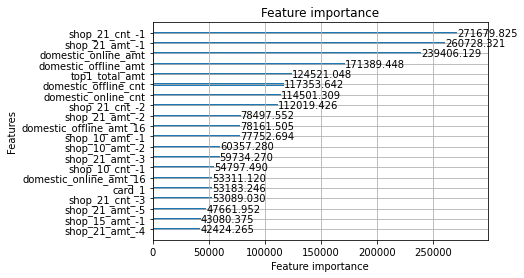

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.89084	valid_1's auc: 0.877468
[100]	training's auc: 0.894238	valid_1's auc: 0.878124
[150]	training's auc: 0.897554	valid_1's auc: 0.878823
[200]	training's auc: 0.901358	valid_1's auc: 0.879472
[250]	training's auc: 0.904894	valid_1's auc: 0.879939
[300]	training's auc: 0.908277	valid_1's auc: 0.880298
[350]	training's auc: 0.911593	valid_1's auc: 0.8806
[400]	training's auc: 0.914635	valid_1's auc: 0.880834
[450]	training's auc: 0.917533	valid_1's auc: 0.88103
[500]	training's auc: 0.919999	valid_1's auc: 0.881193
[550]	training's auc: 0.922037	valid_1's auc: 0.881261
[600]	training's auc: 0.923891	valid_1's auc: 0.881373
[650]	training's auc: 0.925643	valid_1's auc: 0.881398
[700]	training's auc: 0.927162	valid_1's auc: 0.881409
[750]	training's auc: 0.928633	valid_1's auc: 0.881432
[800]	training's auc: 0.929937	valid_1's auc: 0.881432
[850]	training's auc: 0.931175	valid_1's auc: 0.88142
Early sto

<Figure size 864x432 with 0 Axes>

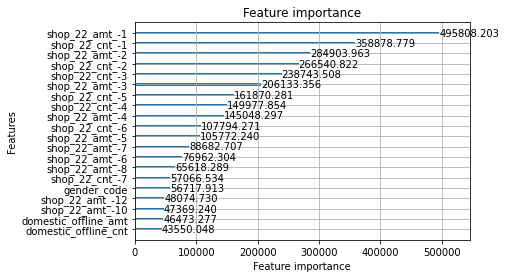

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.87658	valid_1's auc: 0.865463
[100]	training's auc: 0.880155	valid_1's auc: 0.866362
[150]	training's auc: 0.883553	valid_1's auc: 0.867034
[200]	training's auc: 0.887105	valid_1's auc: 0.867637
[250]	training's auc: 0.890697	valid_1's auc: 0.868207
[300]	training's auc: 0.894182	valid_1's auc: 0.868646
[350]	training's auc: 0.89744	valid_1's auc: 0.868972
[400]	training's auc: 0.900537	valid_1's auc: 0.869259
[450]	training's auc: 0.903257	valid_1's auc: 0.869477
[500]	training's auc: 0.905625	valid_1's auc: 0.869617
[550]	training's auc: 0.907792	valid_1's auc: 0.869711
[600]	training's auc: 0.909601	valid_1's auc: 0.869753
[650]	training's auc: 0.911189	valid_1's auc: 0.86978
[700]	training's auc: 0.912561	valid_1's auc: 0.869838
[750]	training's auc: 0.913632	valid_1's auc: 0.869852
[800]	training's auc: 0.914753	valid_1's auc: 0.869855
[850]	training's auc: 0.91577	valid_1's auc: 0.869849
Early st

<Figure size 864x432 with 0 Axes>

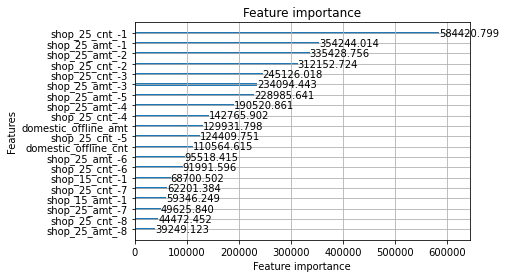

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.892678	valid_1's auc: 0.874384
[100]	training's auc: 0.897302	valid_1's auc: 0.875391
[150]	training's auc: 0.90108	valid_1's auc: 0.875944
[200]	training's auc: 0.904917	valid_1's auc: 0.876336
[250]	training's auc: 0.909034	valid_1's auc: 0.876757
[300]	training's auc: 0.913243	valid_1's auc: 0.877187
[350]	training's auc: 0.917133	valid_1's auc: 0.877463
[400]	training's auc: 0.92025	valid_1's auc: 0.877711
[450]	training's auc: 0.923365	valid_1's auc: 0.87788
[500]	training's auc: 0.925877	valid_1's auc: 0.877998
[550]	training's auc: 0.927663	valid_1's auc: 0.878082
[600]	training's auc: 0.929575	valid_1's auc: 0.878147
[650]	training's auc: 0.931202	valid_1's auc: 0.87821
[700]	training's auc: 0.932746	valid_1's auc: 0.878228
[750]	training's auc: 0.934311	valid_1's auc: 0.878229
[800]	training's auc: 0.935565	valid_1's auc: 0.878198
Early stopping, best iteration is:
[725]	training's auc: 0.9335

<Figure size 864x432 with 0 Axes>

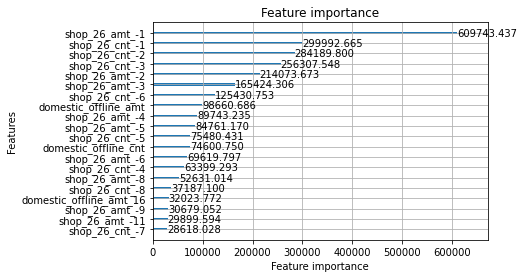

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.942228	valid_1's auc: 0.939236
[100]	training's auc: 0.943518	valid_1's auc: 0.940056
[150]	training's auc: 0.944197	valid_1's auc: 0.94019
[200]	training's auc: 0.945404	valid_1's auc: 0.940823
[250]	training's auc: 0.94649	valid_1's auc: 0.941221
[300]	training's auc: 0.947568	valid_1's auc: 0.941578
[350]	training's auc: 0.948667	valid_1's auc: 0.941835
[400]	training's auc: 0.949692	valid_1's auc: 0.942026
[450]	training's auc: 0.950751	valid_1's auc: 0.942211
[500]	training's auc: 0.951728	valid_1's auc: 0.942387
[550]	training's auc: 0.952586	valid_1's auc: 0.942511
[600]	training's auc: 0.95333	valid_1's auc: 0.942603
[650]	training's auc: 0.953973	valid_1's auc: 0.942691
[700]	training's auc: 0.954554	valid_1's auc: 0.942747
[750]	training's auc: 0.955091	valid_1's auc: 0.942783
[800]	training's auc: 0.955546	valid_1's auc: 0.942813
[850]	training's auc: 0.956009	valid_1's auc: 0.942841
[900]	t

<Figure size 864x432 with 0 Axes>

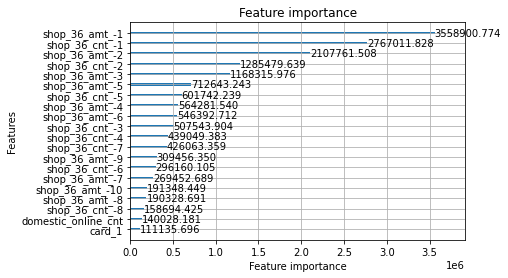

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.879102	valid_1's auc: 0.87562
[100]	training's auc: 0.881034	valid_1's auc: 0.876717
[150]	training's auc: 0.882728	valid_1's auc: 0.877376
[200]	training's auc: 0.884785	valid_1's auc: 0.87837
[250]	training's auc: 0.886537	valid_1's auc: 0.878894
[300]	training's auc: 0.888411	valid_1's auc: 0.879546
[350]	training's auc: 0.890048	valid_1's auc: 0.879875
[400]	training's auc: 0.891651	valid_1's auc: 0.880154
[450]	training's auc: 0.893192	valid_1's auc: 0.880393
[500]	training's auc: 0.89457	valid_1's auc: 0.880602
[550]	training's auc: 0.895805	valid_1's auc: 0.880743
[600]	training's auc: 0.89695	valid_1's auc: 0.880867
[650]	training's auc: 0.898	valid_1's auc: 0.880984
[700]	training's auc: 0.898958	valid_1's auc: 0.881062
[750]	training's auc: 0.899807	valid_1's auc: 0.881119
[800]	training's auc: 0.900594	valid_1's auc: 0.881155
[850]	training's auc: 0.901299	valid_1's auc: 0.881182
[900]	train

<Figure size 864x432 with 0 Axes>

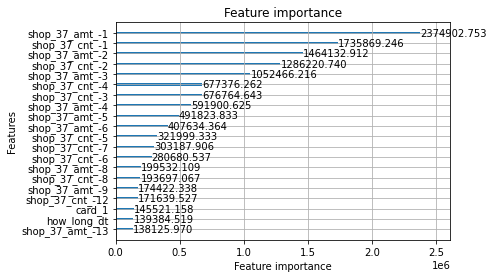

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.877254	valid_1's auc: 0.858759
[100]	training's auc: 0.882744	valid_1's auc: 0.859841
[150]	training's auc: 0.887579	valid_1's auc: 0.860627
[200]	training's auc: 0.892266	valid_1's auc: 0.861274
[250]	training's auc: 0.896506	valid_1's auc: 0.861828
[300]	training's auc: 0.900398	valid_1's auc: 0.862263
[350]	training's auc: 0.903998	valid_1's auc: 0.86265
[400]	training's auc: 0.90738	valid_1's auc: 0.862888
[450]	training's auc: 0.909871	valid_1's auc: 0.863101
[500]	training's auc: 0.911951	valid_1's auc: 0.863246
[550]	training's auc: 0.913848	valid_1's auc: 0.863363
[600]	training's auc: 0.915754	valid_1's auc: 0.863445
[650]	training's auc: 0.91727	valid_1's auc: 0.863484
[700]	training's auc: 0.918761	valid_1's auc: 0.863505
[750]	training's auc: 0.920132	valid_1's auc: 0.863538
[800]	training's auc: 0.92145	valid_1's auc: 0.863524
[850]	training's auc: 0.922718	valid_1's auc: 0.863557
[900]	tr

<Figure size 864x432 with 0 Axes>

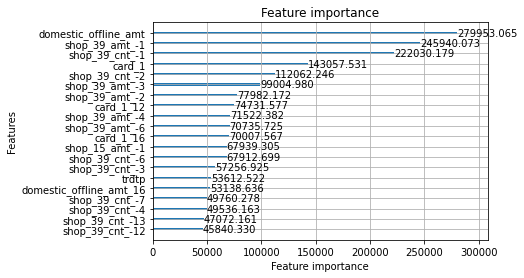

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.910794	valid_1's auc: 0.906162
[100]	training's auc: 0.912666	valid_1's auc: 0.907011
[150]	training's auc: 0.914215	valid_1's auc: 0.907429
[200]	training's auc: 0.916062	valid_1's auc: 0.907995
[250]	training's auc: 0.91781	valid_1's auc: 0.908333
[300]	training's auc: 0.919603	valid_1's auc: 0.908717
[350]	training's auc: 0.921403	valid_1's auc: 0.909025
[400]	training's auc: 0.923145	valid_1's auc: 0.909326
[450]	training's auc: 0.924722	valid_1's auc: 0.909522
[500]	training's auc: 0.926127	valid_1's auc: 0.909661
[550]	training's auc: 0.927379	valid_1's auc: 0.909784
[600]	training's auc: 0.928508	valid_1's auc: 0.909863
[650]	training's auc: 0.929568	valid_1's auc: 0.909935
[700]	training's auc: 0.930332	valid_1's auc: 0.909991
[750]	training's auc: 0.931089	valid_1's auc: 0.910025
[800]	training's auc: 0.931816	valid_1's auc: 0.910052
[850]	training's auc: 0.932427	valid_1's auc: 0.910085
[900]

<Figure size 864x432 with 0 Axes>

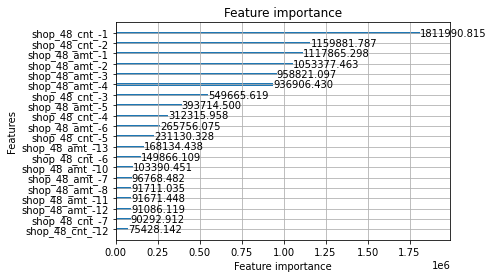

Training fold 3
Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.861338	valid_1's auc: 0.854455
[100]	training's auc: 0.864357	valid_1's auc: 0.855928
[150]	training's auc: 0.86683	valid_1's auc: 0.856687
[200]	training's auc: 0.869261	valid_1's auc: 0.857291
[250]	training's auc: 0.871661	valid_1's auc: 0.857759
[300]	training's auc: 0.873967	valid_1's auc: 0.858196
[350]	training's auc: 0.876172	valid_1's auc: 0.858531
[400]	training's auc: 0.878223	valid_1's auc: 0.858824
[450]	training's auc: 0.880228	valid_1's auc: 0.85904
[500]	training's auc: 0.882027	valid_1's auc: 0.85925
[550]	training's auc: 0.883538	valid_1's auc: 0.859414
[600]	training's auc: 0.884771	valid_1's auc: 0.859552
[650]	training's auc: 0.885953	valid_1's auc: 0.859653
[700]	training's auc: 0.887076	valid_1's auc: 0.859718
[750]	training's auc: 0.888053	valid_1's auc: 0.859765
[800]	training's auc: 0.88893	valid_1's auc: 0.859795
[850]	training's auc: 0.889749	valid_1's auc: 0

<Figure size 864x432 with 0 Axes>

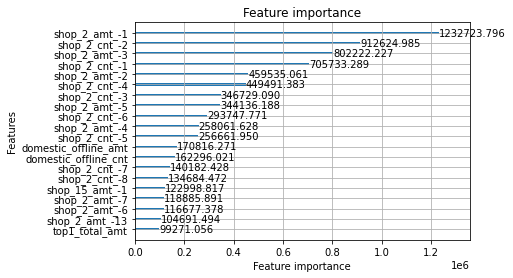

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.911176	valid_1's auc: 0.892477
[100]	training's auc: 0.914886	valid_1's auc: 0.893207
[150]	training's auc: 0.918431	valid_1's auc: 0.893765
[200]	training's auc: 0.92198	valid_1's auc: 0.894365
[250]	training's auc: 0.925474	valid_1's auc: 0.894769
[300]	training's auc: 0.928737	valid_1's auc: 0.895167
[350]	training's auc: 0.931667	valid_1's auc: 0.895442
[400]	training's auc: 0.934401	valid_1's auc: 0.8957
[450]	training's auc: 0.936879	valid_1's auc: 0.89591
[500]	training's auc: 0.939002	valid_1's auc: 0.89608
[550]	training's auc: 0.940737	valid_1's auc: 0.896171
[600]	training's auc: 0.942558	valid_1's auc: 0.896265
[650]	training's auc: 0.944062	valid_1's auc: 0.896313
[700]	training's auc: 0.945335	valid_1's auc: 0.896361
[750]	training's auc: 0.946413	valid_1's auc: 0.896405
[800]	training's auc: 0.947599	valid_1's auc: 0.896392
[850]	training's auc: 0.948593	valid_1's auc: 0.896411
[900]	tra

<Figure size 864x432 with 0 Axes>

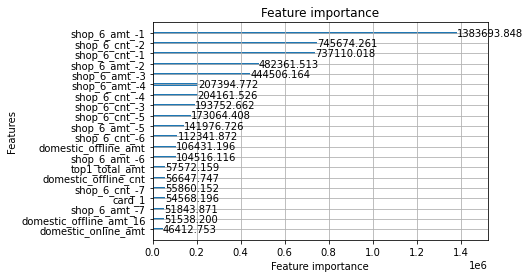

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.925757	valid_1's auc: 0.922028
[100]	training's auc: 0.927488	valid_1's auc: 0.922995
[150]	training's auc: 0.928756	valid_1's auc: 0.92345
[200]	training's auc: 0.930094	valid_1's auc: 0.923811
[250]	training's auc: 0.931559	valid_1's auc: 0.924248
[300]	training's auc: 0.933072	valid_1's auc: 0.924651
[350]	training's auc: 0.934545	valid_1's auc: 0.924972
[400]	training's auc: 0.936077	valid_1's auc: 0.925266
[450]	training's auc: 0.937455	valid_1's auc: 0.925482
[500]	training's auc: 0.938812	valid_1's auc: 0.925753
[550]	training's auc: 0.93994	valid_1's auc: 0.92593
[600]	training's auc: 0.941085	valid_1's auc: 0.926113
[650]	training's auc: 0.941969	valid_1's auc: 0.926229
[700]	training's auc: 0.942902	valid_1's auc: 0.926327
[750]	training's auc: 0.943772	valid_1's auc: 0.926435
[800]	training's auc: 0.944514	valid_1's auc: 0.926496
[850]	training's auc: 0.945229	valid_1's auc: 0.926559
[900]	t

<Figure size 864x432 with 0 Axes>

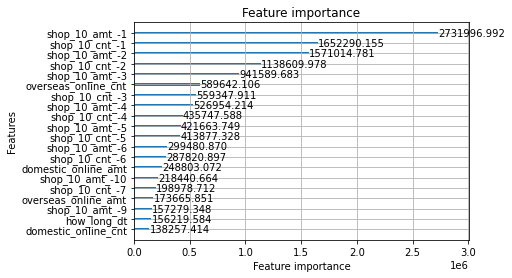

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.924026	valid_1's auc: 0.916247
[100]	training's auc: 0.926131	valid_1's auc: 0.916676
[150]	training's auc: 0.928137	valid_1's auc: 0.917047
[200]	training's auc: 0.930185	valid_1's auc: 0.917378
[250]	training's auc: 0.932404	valid_1's auc: 0.91771
[300]	training's auc: 0.934601	valid_1's auc: 0.917955
[350]	training's auc: 0.936784	valid_1's auc: 0.918199
[400]	training's auc: 0.938777	valid_1's auc: 0.918391
[450]	training's auc: 0.940773	valid_1's auc: 0.918555
[500]	training's auc: 0.942371	valid_1's auc: 0.918709
[550]	training's auc: 0.943821	valid_1's auc: 0.918812
[600]	training's auc: 0.945036	valid_1's auc: 0.918917
[650]	training's auc: 0.946172	valid_1's auc: 0.918982
[700]	training's auc: 0.947157	valid_1's auc: 0.919037
[750]	training's auc: 0.948006	valid_1's auc: 0.919072
[800]	training's auc: 0.94888	valid_1's auc: 0.919102
[850]	training's auc: 0.949589	valid_1's auc: 0.919105
[900]	

<Figure size 864x432 with 0 Axes>

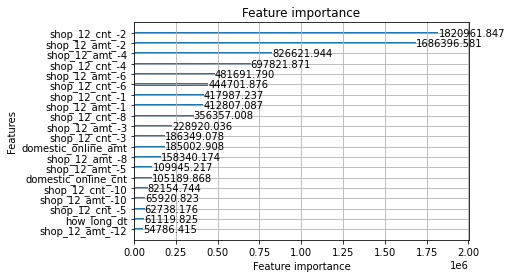

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.959637	valid_1's auc: 0.955086
[100]	training's auc: 0.960713	valid_1's auc: 0.955347
[150]	training's auc: 0.962387	valid_1's auc: 0.955968
[200]	training's auc: 0.964003	valid_1's auc: 0.956458
[250]	training's auc: 0.965519	valid_1's auc: 0.95683
[300]	training's auc: 0.967091	valid_1's auc: 0.957238
[350]	training's auc: 0.968646	valid_1's auc: 0.957571
[400]	training's auc: 0.970223	valid_1's auc: 0.95796
[450]	training's auc: 0.97162	valid_1's auc: 0.95826
[500]	training's auc: 0.972885	valid_1's auc: 0.958501
[550]	training's auc: 0.973918	valid_1's auc: 0.958658
[600]	training's auc: 0.974824	valid_1's auc: 0.958801
[650]	training's auc: 0.975702	valid_1's auc: 0.958996
[700]	training's auc: 0.976422	valid_1's auc: 0.959074
[750]	training's auc: 0.977113	valid_1's auc: 0.959188
[800]	training's auc: 0.977756	valid_1's auc: 0.959275
[850]	training's auc: 0.978318	valid_1's auc: 0.959327
[900]	tr

<Figure size 864x432 with 0 Axes>

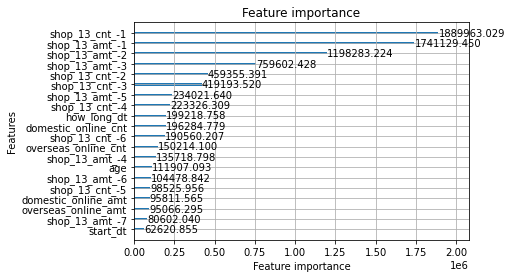

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.879522	valid_1's auc: 0.874773
[100]	training's auc: 0.880909	valid_1's auc: 0.875174
[150]	training's auc: 0.882928	valid_1's auc: 0.876077
[200]	training's auc: 0.884871	valid_1's auc: 0.876764
[250]	training's auc: 0.886816	valid_1's auc: 0.877306
[300]	training's auc: 0.888634	valid_1's auc: 0.877712
[350]	training's auc: 0.890419	valid_1's auc: 0.878133
[400]	training's auc: 0.892125	valid_1's auc: 0.878468
[450]	training's auc: 0.893655	valid_1's auc: 0.87874
[500]	training's auc: 0.895035	valid_1's auc: 0.878954
[550]	training's auc: 0.896161	valid_1's auc: 0.879112
[600]	training's auc: 0.897188	valid_1's auc: 0.879252
[650]	training's auc: 0.898093	valid_1's auc: 0.879363
[700]	training's auc: 0.898907	valid_1's auc: 0.879451
[750]	training's auc: 0.899712	valid_1's auc: 0.879507
[800]	training's auc: 0.900443	valid_1's auc: 0.879566
[850]	training's auc: 0.901139	valid_1's auc: 0.879601
[900]

<Figure size 864x432 with 0 Axes>

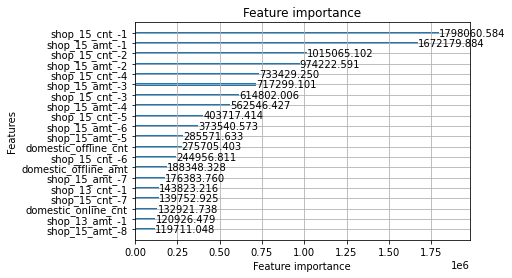

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.870403	valid_1's auc: 0.852667
[100]	training's auc: 0.874748	valid_1's auc: 0.853818
[150]	training's auc: 0.8789	valid_1's auc: 0.854824
[200]	training's auc: 0.883028	valid_1's auc: 0.855447
[250]	training's auc: 0.886862	valid_1's auc: 0.856017
[300]	training's auc: 0.890654	valid_1's auc: 0.856417
[350]	training's auc: 0.894096	valid_1's auc: 0.856778
[400]	training's auc: 0.897107	valid_1's auc: 0.856994
[450]	training's auc: 0.899766	valid_1's auc: 0.857279
[500]	training's auc: 0.901974	valid_1's auc: 0.857445
[550]	training's auc: 0.904046	valid_1's auc: 0.857607
[600]	training's auc: 0.90589	valid_1's auc: 0.857698
[650]	training's auc: 0.907326	valid_1's auc: 0.857748
[700]	training's auc: 0.90859	valid_1's auc: 0.857796
[750]	training's auc: 0.909894	valid_1's auc: 0.857834
[800]	training's auc: 0.911072	valid_1's auc: 0.857861
[850]	training's auc: 0.912159	valid_1's auc: 0.857875
[900]	tr

<Figure size 864x432 with 0 Axes>

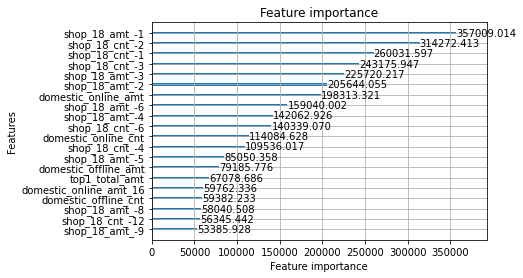

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.830557	valid_1's auc: 0.813364
[100]	training's auc: 0.835457	valid_1's auc: 0.815043
[150]	training's auc: 0.840366	valid_1's auc: 0.816227
[200]	training's auc: 0.845072	valid_1's auc: 0.817314
[250]	training's auc: 0.849561	valid_1's auc: 0.81809
[300]	training's auc: 0.853674	valid_1's auc: 0.8187
[350]	training's auc: 0.857546	valid_1's auc: 0.819237
[400]	training's auc: 0.861056	valid_1's auc: 0.819669
[450]	training's auc: 0.864302	valid_1's auc: 0.820006
[500]	training's auc: 0.867001	valid_1's auc: 0.82027
[550]	training's auc: 0.86951	valid_1's auc: 0.820459
[600]	training's auc: 0.871623	valid_1's auc: 0.820641
[650]	training's auc: 0.873594	valid_1's auc: 0.820801
[700]	training's auc: 0.875537	valid_1's auc: 0.820897
[750]	training's auc: 0.877321	valid_1's auc: 0.820978
[800]	training's auc: 0.878923	valid_1's auc: 0.82105
[850]	training's auc: 0.880406	valid_1's auc: 0.821103
[900]	trai

<Figure size 864x432 with 0 Axes>

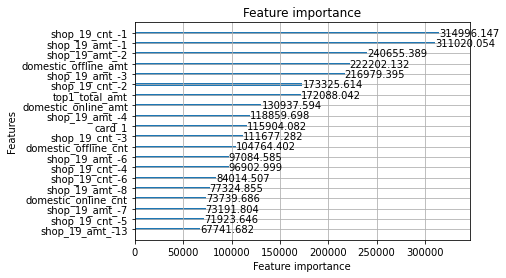

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.841469	valid_1's auc: 0.820443
[100]	training's auc: 0.847435	valid_1's auc: 0.821735
[150]	training's auc: 0.852892	valid_1's auc: 0.822852
[200]	training's auc: 0.858173	valid_1's auc: 0.823735
[250]	training's auc: 0.863114	valid_1's auc: 0.824511
[300]	training's auc: 0.867855	valid_1's auc: 0.825126
[350]	training's auc: 0.871907	valid_1's auc: 0.82559
[400]	training's auc: 0.875508	valid_1's auc: 0.826015
[450]	training's auc: 0.878431	valid_1's auc: 0.826309
[500]	training's auc: 0.880847	valid_1's auc: 0.826538
[550]	training's auc: 0.882783	valid_1's auc: 0.826695
[600]	training's auc: 0.884676	valid_1's auc: 0.826833
[650]	training's auc: 0.886175	valid_1's auc: 0.826904
[700]	training's auc: 0.887559	valid_1's auc: 0.826987
[750]	training's auc: 0.888994	valid_1's auc: 0.826996
[800]	training's auc: 0.890323	valid_1's auc: 0.827052
[850]	training's auc: 0.891742	valid_1's auc: 0.827086
[900]

<Figure size 864x432 with 0 Axes>

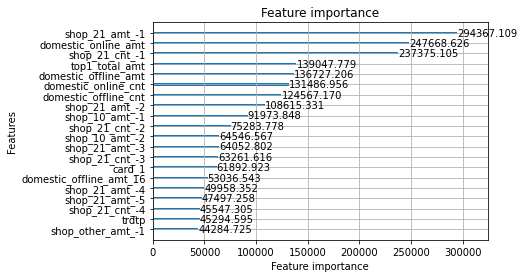

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.889866	valid_1's auc: 0.880045
[100]	training's auc: 0.893468	valid_1's auc: 0.880918
[150]	training's auc: 0.896896	valid_1's auc: 0.881494
[200]	training's auc: 0.900313	valid_1's auc: 0.881831
[250]	training's auc: 0.903854	valid_1's auc: 0.882313
[300]	training's auc: 0.907397	valid_1's auc: 0.882738
[350]	training's auc: 0.910693	valid_1's auc: 0.883058
[400]	training's auc: 0.913883	valid_1's auc: 0.883302
[450]	training's auc: 0.916677	valid_1's auc: 0.88351
[500]	training's auc: 0.918912	valid_1's auc: 0.883592
[550]	training's auc: 0.921079	valid_1's auc: 0.883716
[600]	training's auc: 0.922683	valid_1's auc: 0.883763
[650]	training's auc: 0.924451	valid_1's auc: 0.883817
[700]	training's auc: 0.926096	valid_1's auc: 0.883875
[750]	training's auc: 0.927481	valid_1's auc: 0.883904
[800]	training's auc: 0.928894	valid_1's auc: 0.883907
[850]	training's auc: 0.930096	valid_1's auc: 0.883888
[900]

<Figure size 864x432 with 0 Axes>

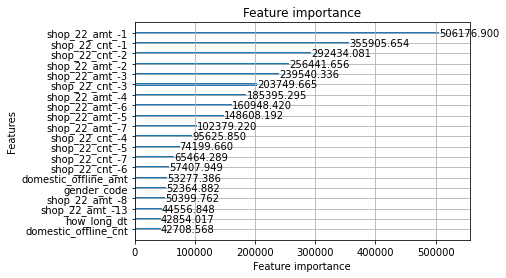

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.877365	valid_1's auc: 0.862652
[100]	training's auc: 0.881076	valid_1's auc: 0.863738
[150]	training's auc: 0.884629	valid_1's auc: 0.864598
[200]	training's auc: 0.888116	valid_1's auc: 0.865105
[250]	training's auc: 0.891594	valid_1's auc: 0.865558
[300]	training's auc: 0.895064	valid_1's auc: 0.866013
[350]	training's auc: 0.898161	valid_1's auc: 0.866322
[400]	training's auc: 0.90126	valid_1's auc: 0.866625
[450]	training's auc: 0.904021	valid_1's auc: 0.866845
[500]	training's auc: 0.906275	valid_1's auc: 0.866987
[550]	training's auc: 0.90836	valid_1's auc: 0.867087
[600]	training's auc: 0.910152	valid_1's auc: 0.867194
[650]	training's auc: 0.91161	valid_1's auc: 0.867263
[700]	training's auc: 0.913132	valid_1's auc: 0.867286
[750]	training's auc: 0.914269	valid_1's auc: 0.867303
[800]	training's auc: 0.915231	valid_1's auc: 0.867297
[850]	training's auc: 0.916231	valid_1's auc: 0.86731
Early st

<Figure size 864x432 with 0 Axes>

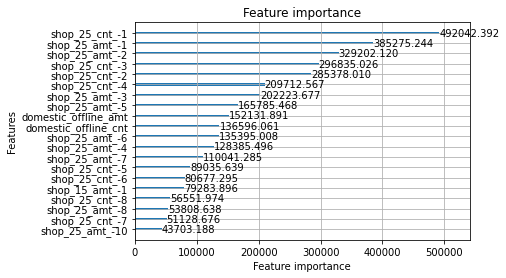

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.892326	valid_1's auc: 0.874012
[100]	training's auc: 0.896704	valid_1's auc: 0.874951
[150]	training's auc: 0.900689	valid_1's auc: 0.875388
[200]	training's auc: 0.904806	valid_1's auc: 0.875868
[250]	training's auc: 0.908854	valid_1's auc: 0.876326
[300]	training's auc: 0.912841	valid_1's auc: 0.876657
[350]	training's auc: 0.916713	valid_1's auc: 0.877004
[400]	training's auc: 0.920263	valid_1's auc: 0.877332
[450]	training's auc: 0.923004	valid_1's auc: 0.8775
[500]	training's auc: 0.925465	valid_1's auc: 0.877669
[550]	training's auc: 0.927638	valid_1's auc: 0.877766
[600]	training's auc: 0.929347	valid_1's auc: 0.877807
[650]	training's auc: 0.930824	valid_1's auc: 0.877906
[700]	training's auc: 0.932155	valid_1's auc: 0.877951
[750]	training's auc: 0.933289	valid_1's auc: 0.877987
[800]	training's auc: 0.934314	valid_1's auc: 0.878027
[850]	training's auc: 0.935813	valid_1's auc: 0.878066
[900]	

<Figure size 864x432 with 0 Axes>

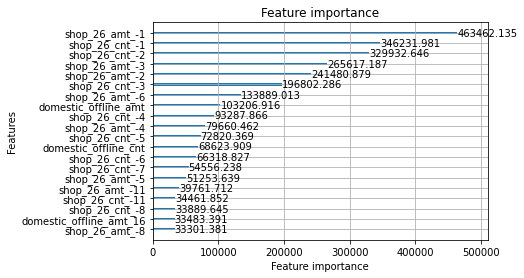

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.942685	valid_1's auc: 0.940381
[100]	training's auc: 0.943693	valid_1's auc: 0.940909
[150]	training's auc: 0.944614	valid_1's auc: 0.941279
[200]	training's auc: 0.945498	valid_1's auc: 0.941521
[250]	training's auc: 0.946555	valid_1's auc: 0.941843
[300]	training's auc: 0.94753	valid_1's auc: 0.942005
[350]	training's auc: 0.94858	valid_1's auc: 0.942248
[400]	training's auc: 0.949598	valid_1's auc: 0.942428
[450]	training's auc: 0.950631	valid_1's auc: 0.942628
[500]	training's auc: 0.951583	valid_1's auc: 0.942769
[550]	training's auc: 0.952426	valid_1's auc: 0.942892
[600]	training's auc: 0.953158	valid_1's auc: 0.942976
[650]	training's auc: 0.953782	valid_1's auc: 0.943044
[700]	training's auc: 0.954396	valid_1's auc: 0.943111
[750]	training's auc: 0.954908	valid_1's auc: 0.943158
[800]	training's auc: 0.955349	valid_1's auc: 0.943205
[850]	training's auc: 0.955768	valid_1's auc: 0.94323
[900]	t

<Figure size 864x432 with 0 Axes>

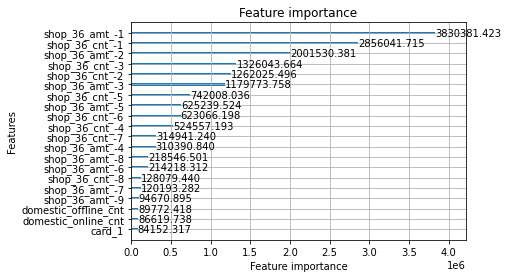

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.880383	valid_1's auc: 0.875456
[100]	training's auc: 0.882163	valid_1's auc: 0.876405
[150]	training's auc: 0.88383	valid_1's auc: 0.87702
[200]	training's auc: 0.885447	valid_1's auc: 0.877565
[250]	training's auc: 0.887082	valid_1's auc: 0.877982
[300]	training's auc: 0.888884	valid_1's auc: 0.878497
[350]	training's auc: 0.890504	valid_1's auc: 0.878874
[400]	training's auc: 0.892141	valid_1's auc: 0.879172
[450]	training's auc: 0.893597	valid_1's auc: 0.879453
[500]	training's auc: 0.894966	valid_1's auc: 0.879632
[550]	training's auc: 0.896195	valid_1's auc: 0.87979
[600]	training's auc: 0.897334	valid_1's auc: 0.879913
[650]	training's auc: 0.898335	valid_1's auc: 0.880025
[700]	training's auc: 0.89924	valid_1's auc: 0.880091
[750]	training's auc: 0.90013	valid_1's auc: 0.880147
[800]	training's auc: 0.900974	valid_1's auc: 0.880212
[850]	training's auc: 0.901705	valid_1's auc: 0.880251
[900]	tra

<Figure size 864x432 with 0 Axes>

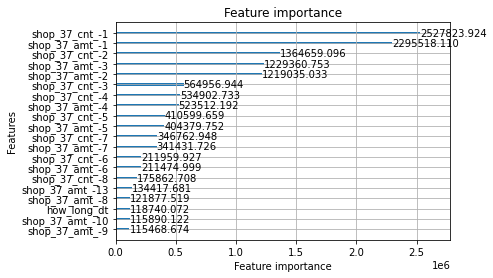

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.876864	valid_1's auc: 0.860343
[100]	training's auc: 0.882052	valid_1's auc: 0.861506
[150]	training's auc: 0.887133	valid_1's auc: 0.862398
[200]	training's auc: 0.891632	valid_1's auc: 0.863032
[250]	training's auc: 0.895899	valid_1's auc: 0.863589
[300]	training's auc: 0.899933	valid_1's auc: 0.863928
[350]	training's auc: 0.903606	valid_1's auc: 0.864303
[400]	training's auc: 0.906612	valid_1's auc: 0.864518
[450]	training's auc: 0.909583	valid_1's auc: 0.86471
[500]	training's auc: 0.912054	valid_1's auc: 0.864863
[550]	training's auc: 0.914316	valid_1's auc: 0.864964
[600]	training's auc: 0.916116	valid_1's auc: 0.865018
[650]	training's auc: 0.917709	valid_1's auc: 0.865049
[700]	training's auc: 0.919412	valid_1's auc: 0.865062
[750]	training's auc: 0.92071	valid_1's auc: 0.86507
[800]	training's auc: 0.922009	valid_1's auc: 0.865101
[850]	training's auc: 0.923458	valid_1's auc: 0.865124
[900]	t

<Figure size 864x432 with 0 Axes>

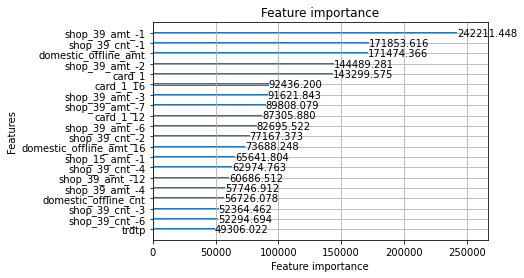

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.911315	valid_1's auc: 0.905632
[100]	training's auc: 0.913126	valid_1's auc: 0.906506
[150]	training's auc: 0.914829	valid_1's auc: 0.90709
[200]	training's auc: 0.916524	valid_1's auc: 0.907482
[250]	training's auc: 0.918234	valid_1's auc: 0.907833
[300]	training's auc: 0.920002	valid_1's auc: 0.908186
[350]	training's auc: 0.921717	valid_1's auc: 0.90842
[400]	training's auc: 0.923435	valid_1's auc: 0.908635
[450]	training's auc: 0.92502	valid_1's auc: 0.908863
[500]	training's auc: 0.926444	valid_1's auc: 0.908998
[550]	training's auc: 0.92765	valid_1's auc: 0.909109
[600]	training's auc: 0.928675	valid_1's auc: 0.9092
[650]	training's auc: 0.929588	valid_1's auc: 0.909257
[700]	training's auc: 0.930428	valid_1's auc: 0.909301
[750]	training's auc: 0.931291	valid_1's auc: 0.909337
[800]	training's auc: 0.932007	valid_1's auc: 0.909352
[850]	training's auc: 0.932598	valid_1's auc: 0.909358
[900]	trai

<Figure size 864x432 with 0 Axes>

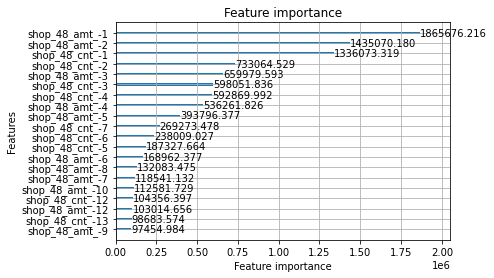

In [19]:
results = {a_cate: [] for a_cate in cnt_handler.ylabels}
train_results = {a_cate: [] for a_cate in cnt_handler.ylabels}

for fold, (trn_ind, val_ind) in enumerate(idx_results):
    print(f'Training fold {fold + 1}')
    for ylabel in cnt_handler.ylabels:
        col_name = ylabel

        X_train, X_val = X.iloc[trn_ind].copy(), X.iloc[val_ind].copy()
        y_train, y_val = y.iloc[trn_ind][col_name].copy(
        ), y.iloc[val_ind][col_name].copy()

        train_dataset = lgb.Dataset(
            X_train, y_train, categorical_feature=profile_handler.cate_feats)
        val_dataset = lgb.Dataset(
            X_val, y_val, categorical_feature=profile_handler.cate_feats)

        model = lgb.train(
            params=params,
            train_set=train_dataset,
            valid_sets=[train_dataset, val_dataset],
            num_boost_round=2000,
            early_stopping_rounds=100,
            verbose_eval=50,
        )

        val_preds = pd.DataFrame(model.predict(X_val))
        train_results[ylabel].append(val_preds)
        plt.figure(figsize=(12, 6))
        lgb.plot_importance(model, max_num_features=20, importance_type='gain')
        plt.title("Feature importance")
        plt.show()
        result = pd.DataFrame(model.predict(cnt_test))
        results[ylabel].append(result)

In [20]:
loader.save_data([results, train_results, idx_results],
                 '2021_12_22_amt_cnt_train_results.joblib',
                 '2021_12_22 rerun generate_train_results')
